### 학습 관련 기술들

**Model 구성 시 성능향상을 위해 고려해야 하는 사항**에 대해서 알아보자.  
아래 링크는 현재 Post에서 구현할 개념을 다룬 내용이다.<br>
<a href="https://wjddyd66.github.io/dl/2019/08/31/NeuralNetwork-(5)-Others.html">NeuralNetwork (5) 학습 관련 기술들</a>

## 1. Settings
### 1) Import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

### 2) Set hyperparameters

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

## 2. Data

### 1) Download Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

### 2) Check Dataset

In [4]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
mnist_test.__getitem__(0)[0].size(), mnist_test.__len__()

torch.Size([1, 28, 28]) 60000


(torch.Size([1, 28, 28]), 10000)

### 3) Set DataLoader

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

### 정형화 

**매우 큰 가중치가 존재**한다고 생각하면 **그 하나의 가중치에 의해서 Model이 결정**되므로 Overfitting된다고 생각할 수 있기 때문이다.  
이러한 가중치 감소는 크게 2가지로 나뉘어 질 수 있다.  
**1) L2 Regularization**: 가장 일반적인 regulization 기법입니다. 기존 손실함수(Lold)에 모든 학습파라메터의 제곱을 더한 식을 새로운 손실함수로 씁니다. 아래 식과 같습니다. 여기에서 1/2이 붙은 것은 미분 편의성을 고려한 것이고, λ는 패널티의 세기를 결정하는 사용자 지정 하이퍼파라메터입니다. 이 기법은 큰 값이 많이 존재하는 가중치에 제약을 주고, 가중치 값을 가능한 널리 퍼지도록 하는 효과를 냅니다.
<p>$$W = [w_1, w_2, ... , w_n]$$</p>
<p>$$L_{new} = L_{old} + \frac{\lambda}{2}(w_1^2 + w_2^2 + ... + w_n^2)$$</p>

**2) L1 Regularization**: 기존 손실함수에 학습파라메터의 절대값을 더해 적용합니다. 이 기법은 학습파라메터를 sparse하게(거의 0에 가깝게) 만드는 특성이 있습니다.
<p>$$L_{new} = L_{old} + \lambda (\left| w_1 \right| + \left| w_2 \right| + ... + \left| w_n \right|)$$</p>

각각의 방식을 그래프로 표현하게 되면 다음과 같다.  
<div><img src="https://miro.medium.com/max/602/1*o6H_R3Do1zpch-3MZk_fjQ.png" height="250" width="600" /></div>

즉, **L1 Regularization에서 Sparse하다는 것은 Weight가 0으로 될 확률이 높다는 것이다.**  
**Sparse**: 전체 w중 0이 많은 경우

위의 공통된 식을 살펴보게 되면 **가중치가 큰 곳에 더 큰 Loss를 더해주는 것**이 핵심이다.  

**Loss 가 커지게 되면** Gradinet Descent 를 생각하였을 때 더욱 더 빨리 최소값에 수렴하게 되고 빨리 수렴하게 되면 무한정으로 커지는 것을 막을 수 있다.  

**Pytorch에서의 Weight Regularization은 weight_decay($\lambda$) Parameter로 조절할 수 있습니다.**
- weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)

**Weight_decay는 L2 Regularization으로 적용되므로 L1 Regularization으로 적용시키기 위해서는 명시적으로 손실함수에 식을 추가해야 한다.**

### Weight Regularization Model

#### 1) CNN Model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

<code>optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.1)</code>  
위의 Code에서 weight_decay=0.1로 설정한다는 것은  
L2 Regularization 식에서  
<p>$$L_{new} = L_{old} + \frac{\lambda}{2}(w_1^2 + w_2^2 + ... + w_n^2)$$</p>
$\lambda$ = 0.1로 설정한다는 것 이다.

#### 2) Loss func & Optimizer

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()

# 정형화는 weight_decay로 줄 수 있습니다.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.1)

cuda:0


#### 3) Train 

In [8]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)          

tensor(2.3047, device='cuda:0', grad_fn=<NllLossBackward>)


#### 4) Test

In [9]:
correct = 0
total = 0

with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 10.35657024383545


### Dropout

Dropout은 **Overfitting**을 막기위한 방법으로 뉴럴 네트워크가 학습중일때, 랜덤하게 뉴런을 꺼서 학습함으로써, 학습이 학습용 데이터로 치우치는 현상을 막아준다.  

<div><img src="https://t1.daumcdn.net/cfile/tistory/224A3941583ED6B109" height="250" width="600" /></div>

**Pytorch에서는 model.train()으로서 Model이 Train상태일 때는 Dropout을 적용하고 model.eval()에서는 Model의 결과를 확인하므로 Dropout을 적용 안한다.**

**또한 중요한점은 정형화나 Dropout의 기법은 항상 결과가 좋아지지 않는다.**  
**기존의 Model에서 제약을 거는 것 이기 때문에 오버피팅하지 않는 상태에서 정형화나 드롭아웃을 넣으면 오히려 학습이 잘 안되는 결과가 나온다.**

### Dropout Model

#### 1) CNN Model

<code>torch.nn.Dropout2d(p=0.5, inplace=False)</code>  
- p: Dropout 시킬 확률
- inplace: 다른 객체를 반환하지 않고 기존 객체를 수정(Default: False)

현재 FeatureMap이 2Dimension이므로 <code>nn.Dropout2d()</code>를 사용하였다.

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(16,32,3,padding=1), # 28
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2,2),            # 14
            nn.Conv2d(32,64,3,padding=1), # 14
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2,2)             # 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

#### 2) Loss func & Optimizer

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

cuda:0


#### 3) Train 

In [12]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)         

tensor(2.3136, device='cuda:0', grad_fn=<NllLossBackward>)


#### 4) Test

Test하는 상태이므로 <code>model.eval()</code>을 통하여 Dropout을 적용시키지 않는다.

In [13]:
correct = 0
total = 0

# 배치정규화나 드롭아웃은 학습할때와 테스트 할때 다르게 동작하기 때문에 모델을 evaluation 모드로 바꿔서 테스트해야합니다.
model.eval()
with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 9.745593070983887


### 데이터 증강
데이터를 증가시키므로 인하여 Model의 성능을 향상시킬 수 있다.  

**Image의 증가를 위해 좌우, 상하 반전, 임의의 크기로 잘라낸 다음 사이즈를 맞추는 등 많은 방법이 존재**  

데이터의 증가시키는 경우 데이터가 Image이면 Pytorch에서 제공하는 **ImageFolder**함수에 넣어서 데이터를 증가시킬 수 있다.  

**ImageFolder**  

<div><code>torchvision.datasets.ImageFolder(root, transform=None, target_transform=None, loader=function default_loader, is_valid_file=None) </code></div>  

**transform.Compose**  

<div><code>torchvision.transforms.Compose(transforms)</code></div>

- tranforms: list of Transform object

image Tranformation을 chained together할 수 있게 해준다.

**transform.Resize**  

<div><code>torchvision.transforms.Resize(size, interpolation=2)</code></div>

- size: 변경하고자 하는 image 크기
- interpolation: Desired interpolation. Default is PIL.Image.BILINEAR

Image 크기 변경.

**transform.RandomResizedCrop**  

<div><code>torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)</code></div>

- size: 샘플링할 Image 크기
- scale: 원본 Image에서 자를 크기
- ratio: 원본 Image에서 자른 크기에서 참조할 비율
- interpolation – Default: PIL.Image.BILINEAR 

랜덤한 위치에서 샘플링.

**transform.RandomHorizontalFlip**  

<div><code>torchvision.transforms.RandomHorizontalFlip(p=0.5)</code></div>

- p: 확률(image 좌우 반전 시킬 확률)

아래 Code는 Image를 증가시키기 위하여 Image를 일정 작업을 거쳐 Return한 것 이다.  

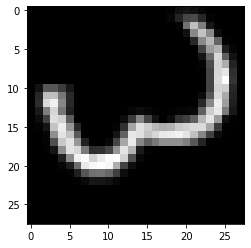

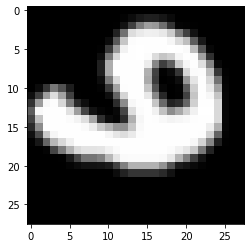

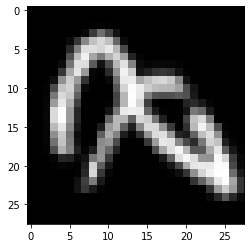

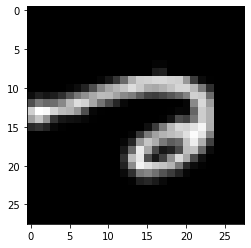

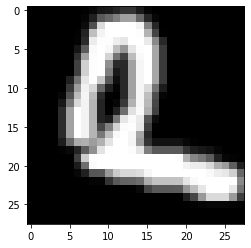

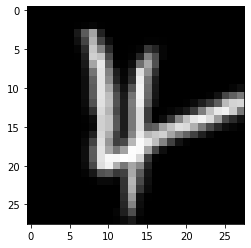

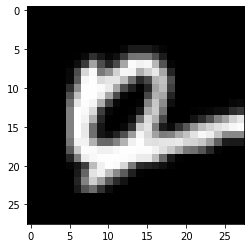

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

mnist_train = dset.MNIST("./", train=True, 
                         transform = transforms.Compose([
                             transforms.Resize(34),                             # 원래 28x28인 이미지를 34x34로 늘립니다.
                             transforms.CenterCrop(28),                         # 중앙 28x28를 뽑아냅니다.
                             transforms.RandomHorizontalFlip(),                 # 랜덤하게 좌우반전 합니다.
                             transforms.Lambda(lambda x: x.rotate(90)),         # 람다함수를 이용해 90도 회전해줍니다.
                             transforms.ToTensor(),                             # 이미지를 텐서로 변형합니다.
                         ]),
                         target_transform=None,
                         download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

for idx,(img,label) in enumerate(train_loader):
  plt.imshow(img[0,0,...],cmap="gray")
  plt.show()
  if idx > 5:
    break

### 가중치의 초깃값
가중치의 초기값을 무엇으로 설정 하느냐가 신경망 학습의 결과에 많은 영향을 미치기 때문에 가중치의 초기값을 어떻게 설정하는지가 Model의 결과에 영향을 많이 미친다.  

**Xavier 방법**  
<code>torch.nn.init.xavier_normal_(tensor, gain=1.0)</code>
$$std = gain * \sqrt{\frac{2}{fan-in + fan-out}}$$

**He 방법**  
<code>torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')</code>
$$std = gain * \sqrt{\frac{2}{(1 + \alpha^2) * fan-in}}$$

- fan-in: Input Node의 개수
- fan-out: Output Node의 개수


<a href="https://nittaku.tistory.com/269">초기값 자세한 설명</a>

### He Model

#### 1) CNN Model

현재 **Activation Function을 ReLU를 사용하므로 가중치 초기화는 He방법 사용**

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )             
        
        # 초기화 하는 방법
        # 모델의 모듈을 차례대로 불러옵니다.
        for m in self.modules():
            # 만약 그 모듈이 nn.Conv2d인 경우
            if isinstance(m, nn.Conv2d):
                '''
                # 작은 숫자로 초기화하는 방법
                # 가중치를 평균 0, 편차 0.02로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0)
                
                # Xavier Initialization
                # 모듈의 가중치를 xavier normal로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0)
                '''
                
                # Kaming Initialization
                # 모듈의 가중치를 kaming he normal로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            
            # 만약 그 모듈이 nn.Linear인 경우
            elif isinstance(m, nn.Linear):
                '''
                # 작은 숫자로 초기화하는 방법
                # 가중치를 평균 0, 편차 0.02로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0)
                
                # Xavier Initialization
                # 모듈의 가중치를 xavier normal로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0)
                '''
                
                # Kaming Initialization
                # 모듈의 가중치를 kaming he normal로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out



#### 2) Loss func & Optimizer

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

cuda:0


#### 3) Train 

In [17]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)   

tensor(1.8078, device='cuda:0', grad_fn=<NllLossBackward>)


#### 4) Test

In [18]:
correct = 0
total = 0

with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 11.929086685180664


### 학습률
<a href="https://wjddyd66.github.io/dl/2019/07/26/NeuralNetwork-(3)-Optimazation.html">NeuralNetwork (3) Optimazation</a>를 보게 되면 Normal Equation과 Gradient Descent비교에서 **Feature가 많이 존재하더라도 학습할 수 있다는 장점**이 존재하고 **대신 Learning Rate를 잘 설정해야 한다는 단점**이 있다고 올렸었다.  
Learning Rate가 너무 크면 발산하게 되고, 너무 작으면 최적의 Weight로서 Update하는데너무 오래 걸릴 가능성이 있다.  
아래 사진을 보게 되면 학습률에 대한 손실 그래프를 보여준다.  

<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/AI/130.PNG" height="250" width="600" /></div>

따라서 실질적으로 Learning Rate를 크게 설정하고 점차 줄여가는 방안으로서 학습하였었다.  

Pytorch에서는 이러한 Learning Rate를 여러번의 Trainning이 아닌 **학습률을 점차 떨어뜨리는 방법**으로서 구현하였다.  

<code>torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1)</code>
- optimizer(Optimizer): Optimizer
- step_size(int): Period of learning rate decay
- gamma(float): Multiplicative factor of learning rate decay
- last_epoch(int): The index of last epoch. Default: -1
정해진 Step_size마다 Learning Rate에 gamma를 곱하여 Learning Rate를 감소

<code>torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)</code>
- optimizer(Optimizer): Optimizer
- milestones (list) – List of epoch indices. Must be increasing.
- gamma(float): Multiplicative factor of learning rate decay
- last_epoch(int): The index of last epoch. Default: -1
Step_size를 List로서 받아서 원하는 지점마다 학습률을 감소

<code>torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)</code>
- optimizer(Optimizer): Optimizer
- gamma(float): Multiplicative factor of learning rate decay
- last_epoch(int): The index of last epoch. Default: -1
매 Epoch마다 Learning Rate에 gamma를 곱하여 Learning Rate를 감소

### ExponentialLR Model

#### 1) CNN Model

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )        
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

#### 2) Loss func & Optimizer

In [20]:
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 지정한 스텝 단위로 학습률에 감마를 곱해 학습률을 감소시킵니다.
#scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma= 0.99)       

# 지정한 스텝 지점(예시에서는 10,30,80)마다 학습률에 감마를 곱해줍니다.
#scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10,30,80], gamma= 0.1)  

# 매 epoch마다 학습률에 감마를 곱해줍니다.
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)                             

print(dir(scheduler))
print(dir(optimizer))

cuda:0
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_step_count', 'base_lrs', 'gamma', 'get_lr', 'last_epoch', 'load_state_dict', 'optimizer', 'state_dict', 'step']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_step_count', 'add_param_group', 'defaults', 'load_state_dict', 'param_groups', 'state', 'state_dict', 'step', 'zero_grad']


#### 3) Train 

In [21]:
for i in range(num_epoch):
    scheduler.step()  
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
          
    
    if i % 10 == 0:
        print(loss)   
            
    #print("Epoch: {}, Learning Rate: {}".format(i,scheduler.get_lr()))  
    print("Epoch: {}, Learning Rate: {}".format(i,scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

/home/theia/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


tensor(2.3146, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 0, Learning Rate: 0.00019800000000000002
Epoch: 1, Learning Rate: 0.00019602
Epoch: 2, Learning Rate: 0.0001940598
Epoch: 3, Learning Rate: 0.000192119202
Epoch: 4, Learning Rate: 0.00019019800998
Epoch: 5, Learning Rate: 0.0001882960298802
Epoch: 6, Learning Rate: 0.00018641306958139798
Epoch: 7, Learning Rate: 0.00018454893888558403
Epoch: 8, Learning Rate: 0.00018270344949672818
Epoch: 9, Learning Rate: 0.00018087641500176088


#### 4) Test

In [22]:
correct = 0
total = 0

with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 11.648637771606445


### Normalization
정규화의 종류로는 크게 2가지가 존재한다.
- 표준 정규화: $\hat{x} = \frac{x - m}{\alpha}$
- 최소극대화 정규화: $x = (x - min(x))/(max(x) - min(x))$

**정규화의 문제로는 너무 작거나 큰 이상치가 있는 경우에는 오히려 학습에 방해가 되는 경우도 발생한다.**  

아래 그림은 정규화를 하였을때 장점중 하나를 표현한 것이다.
<div><img src="http://jsideas.net/assets/img/20180128.png" height="250" width="600" /></div>

위의 그림과 같이 데이터의 각 요소별 범위가 같은 비율로서 Update함으로써 더 빠른 Update를 기대할 수 있다.

### Normalization Model

#### 1) 데이터 정규화
transforms.Normalization을 통화여 정규화가 가능하다.  
각각의 Parameter가 여러개인 것은 들어오는 Input Image의 Channel을 모르기 때문이다.

In [23]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                         ]),
                         target_transform=None, 
                         download=True)
mnist_test = dset.MNIST("./", train=False, 
                        transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

#### 2) CNN Model

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )        
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

#### 3) Loss func & Optimizer

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

cuda:0


#### 4) Train 

In [26]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)          

tensor(2.2997, device='cuda:0', grad_fn=<NllLossBackward>)


#### 5) Test

In [27]:
correct = 0
total = 0

with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 34.15464782714844


### Batch Normalization

**배치 정규화**는 활성함수의 활성화값 또는 출력값을 정규화 하는 작업을 의미한다. 이는 데이터 분포가 치우치는 현상을 해결함으로써 가중치가 엉뚱한 방향으로 갱신될 문제를 해결할 수 있다.  

배치 정규화의 과정은 아래와 같은 그림으로 나타낼 수 있다.  

<div><img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile29.uf.tistory.com%2Fimage%2F994586445BBE000E15CC3D" height="250" width="600" /></div>

위의 그림으로서 데이터의 분포가 평균이 0, 분산이 1이 되도록 정규화를 한다.  
수식으로는 아래와 같이 나타낼 수 있다.  

<p>$$ \mu_B \leftarrow \frac{1}{m}\sum_{i=1}^m x_i$$</p>
<p>$$ \sigma_B^2 \leftarrow \frac{1}{m}\sum_{i=1}^m (x_i-\mu_B)^2$$</p>
<p>$$ \hat{x_i} \leftarrow \frac{x_i-\mu_B}{\sqrt{\sigma_B^2 + \varepsilon}}$$</p>
<p>$$ B = {x_1, x_2, ... , x_m} $$</p>

위의 식에서 알 수 있듯이 m개의 입력 데이터의 집합에 대해 평균 <span>$ \mu_B$</span>와 분산<span>$ \sigma_B^2$</span>를 구한다.  
그리고 입력 데이터를 평균이 0, 분산이 1이 되게 정규화를 실시한다.  
<span>$ \varepsilon $</span>는 매우 작은 값으로서 <span>$\frac{x_i-\mu_B}{\sqrt{\sigma_B^2 + \varepsilon}} $</span>의 값이 inf가 되는 것을 방지한다.  

Pytorch에서는 nn.BatchNorm()으로서 구성한다.  
또한 **DropOut기법과 똑같이 Train에서는 BatchNormalization을 실시하고 평가할때는 model.eval()을 통하여 BatchNormalization을 실시하지 않는다.**  

**위에서도 알 수 있듯이 Normalization은 Train Dataset과 Test Dataset을 똑같이 Normalization을 시켜서 Update하는 거라면 Batch Normalization은 같은 Batch Data끼리의 Normalization을 통하여 Update하는 것 이다.**

### Batch Normalization Model

#### 1) 데이터 Batch

In [28]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

#### 2) CNN Model

In [29]:
# 입력 데이터를 정규화하는것처럼 연산을 통과한 결과값을 정규화할 수 있습니다.
# 그 다양한 방법중에 대표적인것이 바로 Batch Normalization이고 이는 컨볼루션 연산처럼 모델에 한 층으로 구현할 수 있습니다.
# https://pytorch.org/docs/stable/nn.html?highlight=batchnorm#torch.nn.BatchNorm2d
# nn.BatchNorm2d(x)에서 x는 입력으로 들어오는 채널의 개수입니다.

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

#### 3) Loss func & Optimizer

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

cuda:0


#### 4) Train 

In [31]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)                

tensor(1.5503, device='cuda:0', grad_fn=<NllLossBackward>)


#### 5) Test

In [32]:
correct = 0
total = 0

# 배치정규화나 드롭아웃은 학습할때와 테스트 할때 다르게 동작하기 때문에 모델을 evaluation 모드로 바꿔서 테스트해야합니다.
model.eval()
with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 92.7383804321289


### 다양한 Optimazation
<a href="https://wjddyd66.github.io/dl/2019/07/26/NeuralNetwork-(3)-Optimazation2.html">NeuralNetwork (3) Optimazation2</a>에 Optimizer가 고려해야 하는 사항과 다양한 Optimizer를 소개하였다.  
Pytorch에서는 torch.optim에서 이러한 종류를 구현하여서 제공하고 있다.

**SGD**  
<code>torch.optim.SGD(params, lr=required parameter, momentum=0, dampening=0, weight_decay=0, nesterov=False)</code>

**AdaGrad**  
<code>torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)</code>

**RMS Prop**  
<code>torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)</code>

**Adam**  
<code>torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)</code>